# VGG_19--Playing with image

--make the picture into Van_Gogh style

In [1]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time

from keras.applications import vgg19
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
!wget https://www.adaymag.com/wp-content/uploads/2016/07/adaymag-pink-city-04-650x429.jpg

--2021-01-06 00:53:01--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37490 (37K) [image/jpeg]
Saving to: ‘300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg’

300px-Van_Gogh_-_St 100%[===================>]  36.61K  --.-KB/s    in 0.03s   

2021-01-06 00:53:01 (1.29 MB/s) - ‘300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg’ saved [37490/37490]

--2021-01-06 00:53:01--  https://www.adaymag.com/wp-content/uploads/2016/07/adaymag-pink-city-04-650x429.jpg
Resolving www.adaymag.com (www.adaymag.com)... 104.26.1.240, 104.26.0.240, 172.67.74.167
Connecting to www.adaymag.com (www.adaymag.com)|104.26.1.240|:443... connected.
HTTP requ

Populating the interactive namespace from numpy and matplotlib


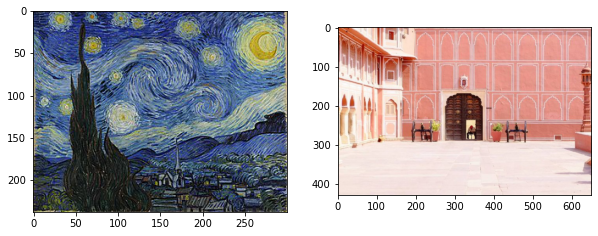

In [3]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
fig1=mpimg.imread('300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
imgplot = plt.imshow(fig1)
fig.add_subplot(1,2,2)
fig2 = mpimg.imread('adaymag-pink-city-04-650x429.jpg')
imgplot = plt.imshow(fig2)
plt.show()

In [4]:
#style_image=Van_Gogh, origin=pink_city
base_image_path = "adaymag-pink-city-04-650x429.jpg"
style_reference_image_path = "300px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
result_prefix = "img"
iterations = 10

# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025

# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [5]:
# 打开并修改图片大小以适合模型
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [6]:
# 将 cell 转成图片
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    if K.image_data_format() == 'channels_first':
        features = K.batch_flatten(x)
    else:
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    if K.image_data_format() == 'channels_first':
        a = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
        b = K.square(
            x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    else:
        a = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
        b = K.square(
            x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [8]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [9]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [10]:
# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

80142336/80134624 [==============================] - 0s 0us/step
Model loaded.


In [11]:
evaluator = Evaluator()

In [12]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 7707641000.0
Image saved as img_at_iteration_0.png
Iteration 0 completed in 464s
Start of iteration 1
Current loss value: 4882982400.0
Image saved as img_at_iteration_1.png
Iteration 1 completed in 458s
Start of iteration 2
Current loss value: 4255487500.0
Image saved as img_at_iteration_2.png
Iteration 2 completed in 460s
Start of iteration 3
Current loss value: 3883568600.0
Image saved as img_at_iteration_3.png
Iteration 3 completed in 458s
Start of iteration 4
Current loss value: 3636776000.0
Image saved as img_at_iteration_4.png
Iteration 4 completed in 459s
Start of iteration 5
Current loss value: 3463846000.0
Image saved as img_at_iteration_5.png
Iteration 5 completed in 458s
Start of iteration 6
Current loss value: 3339007200.0
Image saved as img_at_iteration_6.png
Iteration 6 completed in 457s
Start of iteration 7
Current loss value: 3207090200.0
Image saved as img_at_iteration_7.png
Iteration 7 completed in 456s
Start of iteration 8
Cur

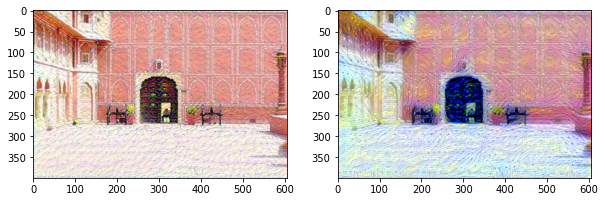

In [13]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(1,2,1)
fig1=mpimg.imread('img_at_iteration_0.png')
imgplot = plt.imshow(fig1)
fig.add_subplot(1,2,2)
fig2 = mpimg.imread('img_at_iteration_9.png')
imgplot = plt.imshow(fig2)
plt.show()